In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
import pathlib
import datetime
import time

# Age classification

## Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir='/content/drive/MyDrive/ce4042/classified_age_images'
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/drive/MyDrive/ce4042/classified_age_images')

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

12653

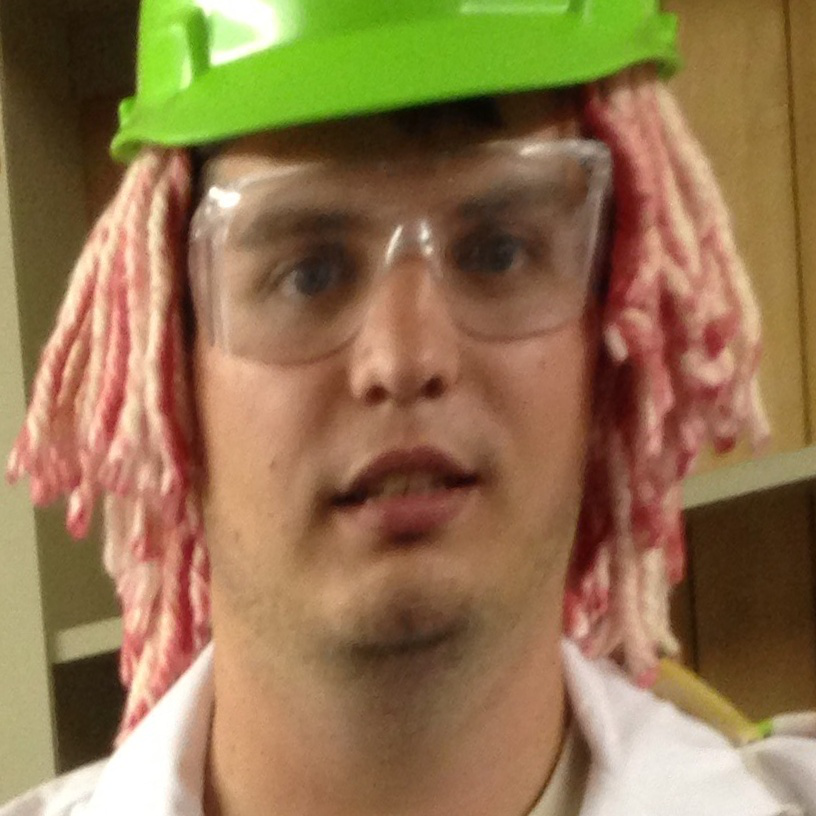

In [ ]:
age_15_23 = list(data_dir.glob('age_15_23/*'))
PIL.Image.open(str(age_15_23[0]))

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

#Splitting dataset to train and val 0.9 to 0.1
train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_dir),
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_dir),
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12653 files belonging to 7 classes.
Using 11388 files for training.
Found 12653 files belonging to 7 classes.
Using 1265 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['age_0_3', 'age_15_23', 'age_25_32', 'age_34_54', 'age_4_6', 'age_55_100', 'age_8_13']


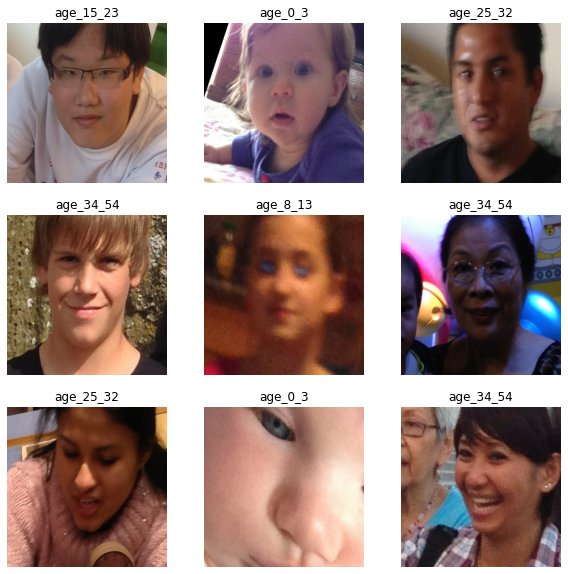

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


## Data augmentation

In [ ]:
#apply data augmentation flip and rotation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2)  
])

In [ ]:
batch_size = 32

def prepare(ds, augment=False):
  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(train_ds, augment=True)
val_ds = prepare(val_ds)

## Building model

In [ ]:
num_classes = len(class_names)

#model from gender classification
model = Sequential([
  layers.Conv2D(16, 3, input_shape=(img_width,img_height,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)      

In [ ]:
#Defining early stopping
def early_stop_callback(name):
  return [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]

In [ ]:
#Callback to restore best model weights 
checkpoint_filepath = './best_weights_file'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
NUM_EPOCHS = 200

history = model.fit(train_ds,
                    validation_data=val_ds,
                    batch_size=32,
                    epochs=NUM_EPOCHS,
                    callbacks = [early_stop_callback("early"), model_checkpoint_callback])

Epoch 1/200
356/356 [==============================] - 30s 83ms/step - loss: 1.3708 - accuracy: 0.4568 - val_loss: 1.3349 - val_accuracy: 0.4704
Epoch 2/200
356/356 [==============================] - 28s 78ms/step - loss: 1.3311 - accuracy: 0.4823 - val_loss: 1.3713 - val_accuracy: 0.4482
Epoch 3/200
356/356 [==============================] - 29s 82ms/step - loss: 1.2957 - accuracy: 0.4944 - val_loss: 1.3098 - val_accuracy: 0.4656
Epoch 4/200
356/356 [==============================] - 28s 78ms/step - loss: 1.2630 - accuracy: 0.5076 - val_loss: 1.3410 - val_accuracy: 0.4664
Epoch 5/200
356/356 [==============================] - 29s 82ms/step - loss: 1.2371 - accuracy: 0.5208 - val_loss: 1.2436 - val_accuracy: 0.4980
Epoch 6/200
356/356 [==============================] - 28s 78ms/step - loss: 1.2100 - accuracy: 0.5326 - val_loss: 1.2792 - val_accuracy: 0.4719
Epoch 7/200
356/356 [==============================] - 29s 82ms/step - loss: 1.1873 - accuracy: 0.5415 - val_loss: 1.2068 - val_ac

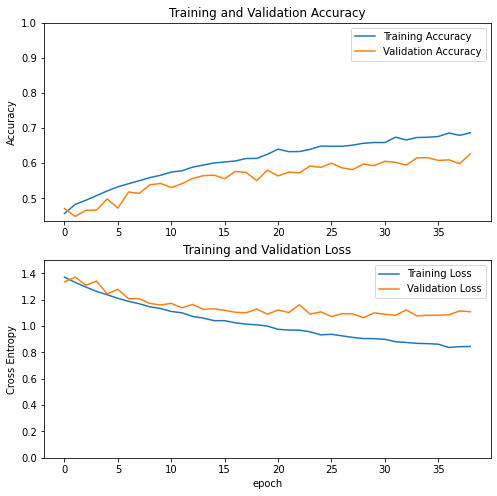

In [ ]:
# plotting performance with the model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# performance of the model for age classification
lowest_val_loss = min(history.history['val_loss'])
lowest_loss_index = np.argmin(history.history['val_loss'])
val_acc = history.history['val_accuracy'][lowest_loss_index]
print("lowest val loss = ", lowest_val_loss)
print("val accuracy = ", val_acc)

lowest val loss =  1.0627524852752686
val accuracy =  0.5976284742355347


## Optimizing model

### 1. Changing number of hidden neurons for fully connected layer

In [ ]:
#testing number of hidden neurons for dense layer

no_neurons = [128,256,512]
optimal_loss = []
optimal_acc = []
for i in no_neurons:
    optimal_model = Sequential([
                                #layers.Rescaling(1./255),
                                layers.Conv2D(16, 3, input_shape=(img_width,img_height,3), padding='same', activation='relu'),
                                layers.MaxPooling2D(),
                                layers.Conv2D(32, 3, padding='same', activation='relu'),
                                layers.MaxPooling2D(),
                                layers.Conv2D(64, 3, padding='same', activation='relu'),
                                layers.MaxPooling2D(),
                                layers.Conv2D(128, 3, padding='same', activation='relu'),
                                layers.MaxPooling2D(),
                                layers.Conv2D(256, 3, padding='same', activation='relu'),
                                layers.MaxPooling2D(),
                                layers.Flatten(),
                                layers.Dense(i, activation='relu'),
                                layers.Dense(num_classes)
    ])
    optimal_model.compile(
                  optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['acc'])
    optimal_model.summary()
    optimal_history = optimal_model.fit(train_ds,
                                validation_data=val_ds,
                                batch_size=32,
                                epochs=200,
                                callbacks = [early_stop_callback("early"), model_checkpoint_callback]
                                )
    optimal_loss.append(min(optimal_history.history['val_loss']))
    lowest_loss_index = np.argmin(optimal_history.history['val_loss'])
    optimal_acc.append(optimal_history.history['val_accuracy'][lowest_loss_index])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 32, 32, 64)      

In [ ]:
# plot validation loss for each number of neurons
df = pd.DataFrame(np.array([optimal_loss]),                  
                   columns=[ 
                              "128",
                              "256",
                              "512"],
                   index=['loss'])
                
df


,128,256,512
loss,1.06577,1.047062,1.07968


In [ ]:
# plot validation accuracy for each number of neurons
df2 = pd.DataFrame(np.array([optimal_acc]),                  
                   columns=[ 
                              "128",
                              "256",
                              "512"],
                   index=['accuracy'])
                
df2

,128,256,512
accuracy,0.603953,0.624506,0.633992


## Final model

In [ ]:
#define final model with 256 neurons
num_classes = len(class_names)

final_model = Sequential([
                                layers.Conv2D(16, 3, input_shape=(img_width,img_height,3), padding='same', activation='relu'),
                                layers.MaxPooling2D(),
                                layers.Conv2D(32, 3, padding='same', activation='relu'),
                                layers.MaxPooling2D(),
                                layers.Conv2D(64, 3, padding='same', activation='relu'),
                                layers.MaxPooling2D(),
                                layers.Conv2D(128, 3, padding='same', activation='relu'),
                                layers.MaxPooling2D(),
                                layers.Conv2D(256, 3, padding='same', activation='relu'),
                                layers.MaxPooling2D(),
                                layers.Flatten(),
                                layers.Dense(256, activation='relu'),
                                layers.Dense(num_classes)
    ])

In [ ]:
final_model.compile(
                  optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['acc'])
final_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 64)      

In [ ]:
final_history = final_model.fit(train_ds,
                                validation_data=val_ds,
                                batch_size=32,
                                epochs=200,
                                callbacks = [early_stop_callback("early"), model_checkpoint_callback]
                                )

Epoch 1/200
356/356 [==============================] - 59s 158ms/step - loss: 1.8021 - acc: 0.2979 - val_loss: 1.7670 - val_acc: 0.2933
Epoch 2/200
356/356 [==============================] - 30s 82ms/step - loss: 1.7176 - acc: 0.3377 - val_loss: 1.5390 - val_acc: 0.4095
Epoch 3/200
356/356 [==============================] - 29s 82ms/step - loss: 1.5848 - acc: 0.3906 - val_loss: 1.4040 - val_acc: 0.4364
Epoch 4/200
356/356 [==============================] - 30s 83ms/step - loss: 1.4445 - acc: 0.4342 - val_loss: 1.3853 - val_acc: 0.4474
Epoch 5/200
356/356 [==============================] - 28s 79ms/step - loss: 1.3639 - acc: 0.4653 - val_loss: 1.3989 - val_acc: 0.4364
Epoch 6/200
356/356 [==============================] - 30s 83ms/step - loss: 1.3145 - acc: 0.4910 - val_loss: 1.3131 - val_acc: 0.4791
Epoch 7/200
356/356 [==============================] - 30s 83ms/step - loss: 1.2789 - acc: 0.5017 - val_loss: 1.2734 - val_acc: 0.4972
Epoch 8/200
356/356 [==============================] -

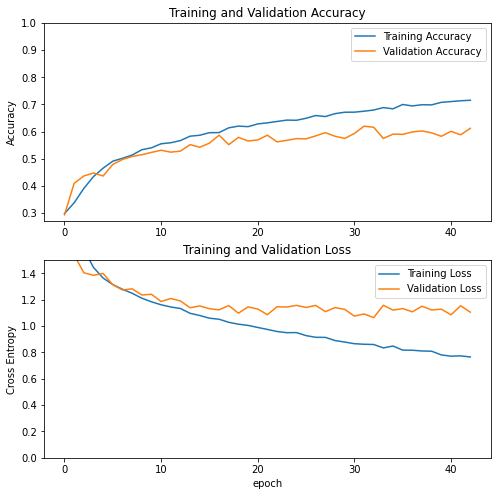

In [ ]:
# plotting performance of the final model
acc = final_history.history['acc']
val_acc = final_history.history['val_acc']

loss = final_history.history['loss']
val_loss = final_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# performance of final model
lowest_val_loss = min(final_history.history['val_loss'])
lowest_loss_index = np.argmin(final_history.history['val_loss'])
val_acc = final_history.history['val_acc'][lowest_loss_index]
print("lowest val loss = ", lowest_val_loss)
print("val accuracy = ", val_acc)

lowest val loss =  1.0639710426330566
val accuracy =  0.6158102750778198


## Predictions

In [ ]:
class_names

['age_0_3',
 'age_15_23',
 'age_25_32',
 'age_34_54',
 'age_4_6',
 'age_55_100',
 'age_8_13']

In [ ]:
# predict age group of images
predicted_batch = final_model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_id
predicted_label_batch=[]
for i in predicted_id.numpy():
    if(i==0):
        predicted_label_batch.append("age_0_3")
    elif(i==1):
        predicted_label_batch.append("age_15_23")
    elif(i==2):
        predicted_label_batch.append("age_25_32")  
    elif(i==3):
        predicted_label_batch.append("age_34_54")
    elif(i==4):
        predicted_label_batch.append("age_4_6") 
    elif(i==5):
        predicted_label_batch.append("age_55_100")
    elif(i==6):
        predicted_label_batch.append("age_8_13")     
print(predicted_label_batch)

['age_34_54', 'age_34_54', 'age_4_6', 'age_0_3', 'age_34_54', 'age_8_13', 'age_15_23', 'age_4_6', 'age_25_32', 'age_25_32', 'age_0_3', 'age_0_3', 'age_8_13', 'age_25_32', 'age_0_3', 'age_25_32', 'age_34_54', 'age_4_6', 'age_25_32', 'age_0_3', 'age_34_54', 'age_34_54', 'age_25_32', 'age_34_54', 'age_4_6', 'age_25_32', 'age_8_13', 'age_25_32', 'age_0_3', 'age_25_32', 'age_0_3', 'age_15_23']


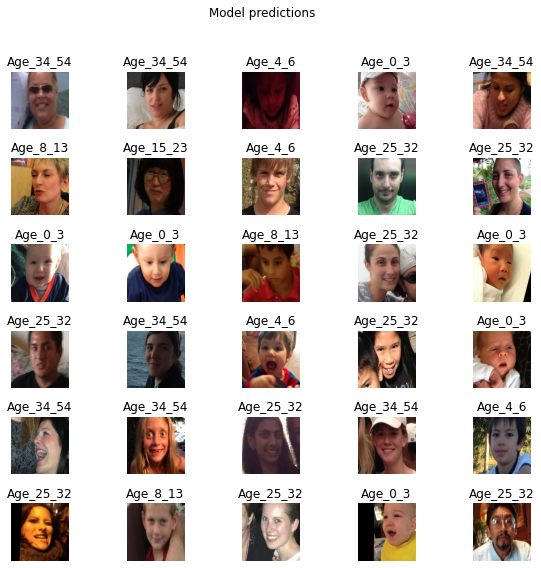

In [ ]:
# plotting the result images with predicted age group
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")